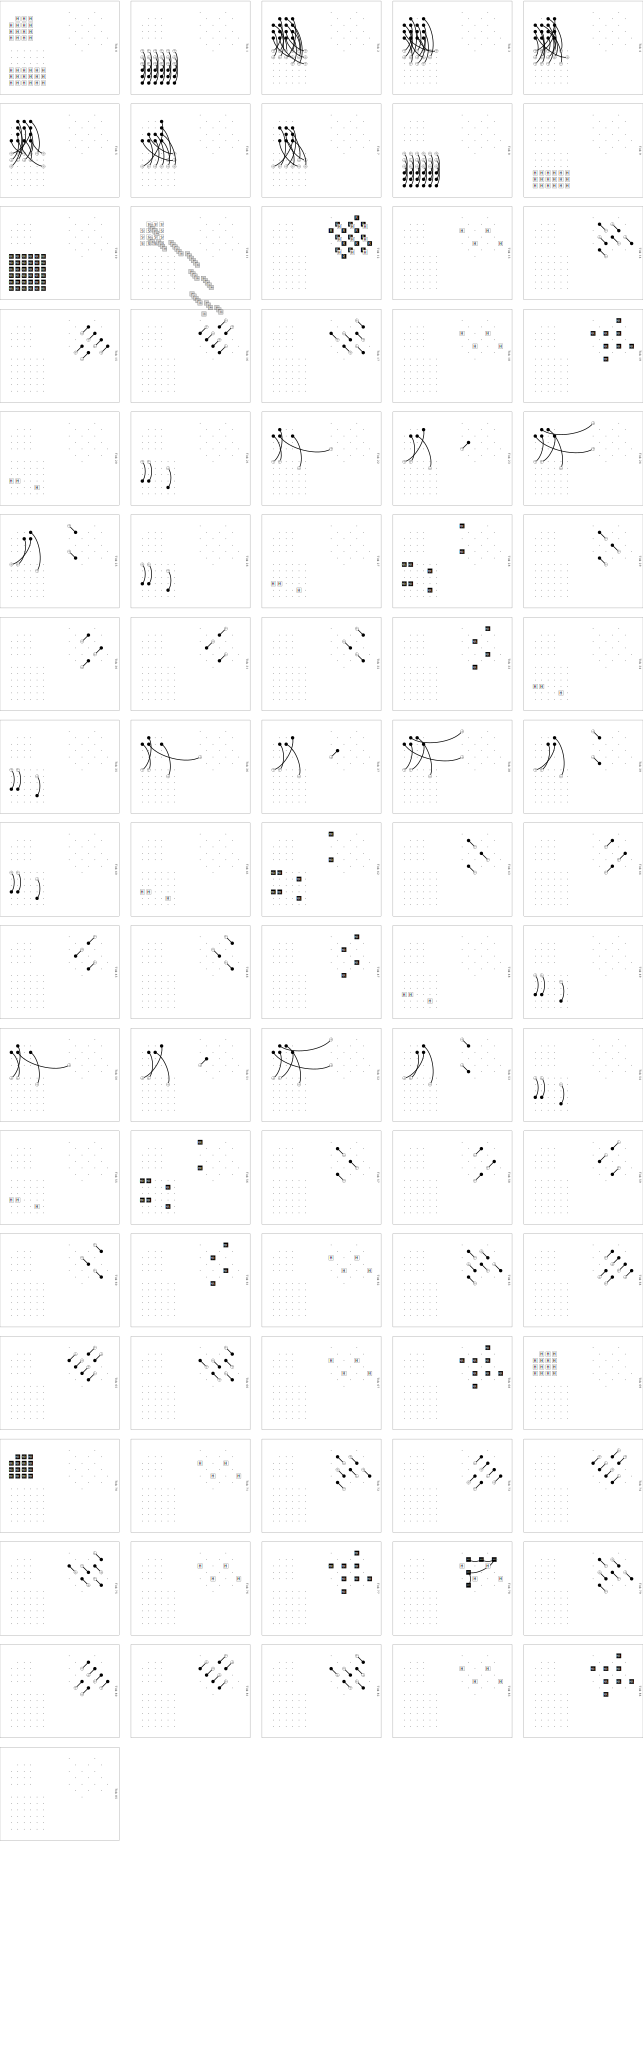

In [9]:
import src.magic as magic

circuit = magic.magic_preparation(
    T_sc_pre=0,
    T_lat_surg=3,
    T_before_grow=1,
    # T_ps_grow=2,
    # T_maintain=2,  # 注意这里使用循环变量
    error_rate=1e-3
)

circuit.without_noise().diagram('timeslice-svg', rows=20)

In [2]:
def check_dem_dist_errors(dem):
    """
    一步到位检查 Distance=1 (纯L0) 和 Distance=2 (仅相差L0) 的错误。
    修复了 L0 L0 互相抵消导致的误报问题，并过滤掉无意义的 ^ 符号。
    """
    import re
    
    # 存储格式: normalized_detectors -> has_logical_flip
    # normalized_detectors 是一个排序后的 detector tuple (如 ('D0', 'D1'))
    # has_logical_flip 是布尔值，True 表示 L0 出现奇数次
    error_map = {}
    
    # 1. 解析 DEM
    for line in str(dem).splitlines():
        line = line.strip()
        if line.startswith("error("):
            m = re.match(r"error\([^\)]+\)\s+(.*)", line)
            if m:
                raw_items = m.group(1).split()
                
                detectors = []
                l0_count = 0
                
                for item in raw_items:
                    if item == "^":
                        continue # 忽略格式符
                    elif item == "L0":
                        l0_count += 1
                    elif item.startswith("D"):
                        detectors.append(item)
                
                # 标准化 detector 组合
                det_key = tuple(sorted(detectors))
                #如果在二进制下，L0 出现偶数次等于没出现
                is_logical_flipped = (l0_count % 2 == 1)
                
                # 我们只关心存在的错误形式
                # 如果同一个 detector 组合既以 "flipped" 出现，又以 "not flipped" 出现，
                # 说明存在 distance 2 的错误。
                
                # 记录该 detector 组合目前见过的逻辑状态
                if det_key not in error_map:
                    error_map[det_key] = set()
                error_map[det_key].add(is_logical_flipped)
    d1_errors = []
    d2_pairs = []
    for detectors, states in error_map.items():
        # 检查 Distance = 1:
        # 如果 detectors 为空 (没有触发探测器)，且状态为 True (有逻辑翻转)
        if len(detectors) == 0 and True in states:
            d1_errors.append("Pure L0 error (undetected)")
            
        # 检查 Distance = 2:
        # 如果同一个 detector 组合，既有 True (翻转) 又有 False (未翻转) 的情况
        if True in states and False in states:
            d2_pairs.append((detectors, tuple(list(detectors) + ["L0"])))
    return d1_errors, d2_pairs

In [3]:
dem = circuit.detector_error_model()
check_dem_dist_errors(dem)

([], [])

In [10]:
import numpy as np

def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

In [19]:
get_wilson_interval(195, 3410)

(0.05718475073313783, 0.04987801899518775, 0.06548808352110942)